Science image exposure time: 30.0 seconds
Found masterdark with matching exposure time: winter_masterdark_30.000s.fits
shape of masterdark single image: (1096, 1984)
shape of raw science frame: (1096, 1984)


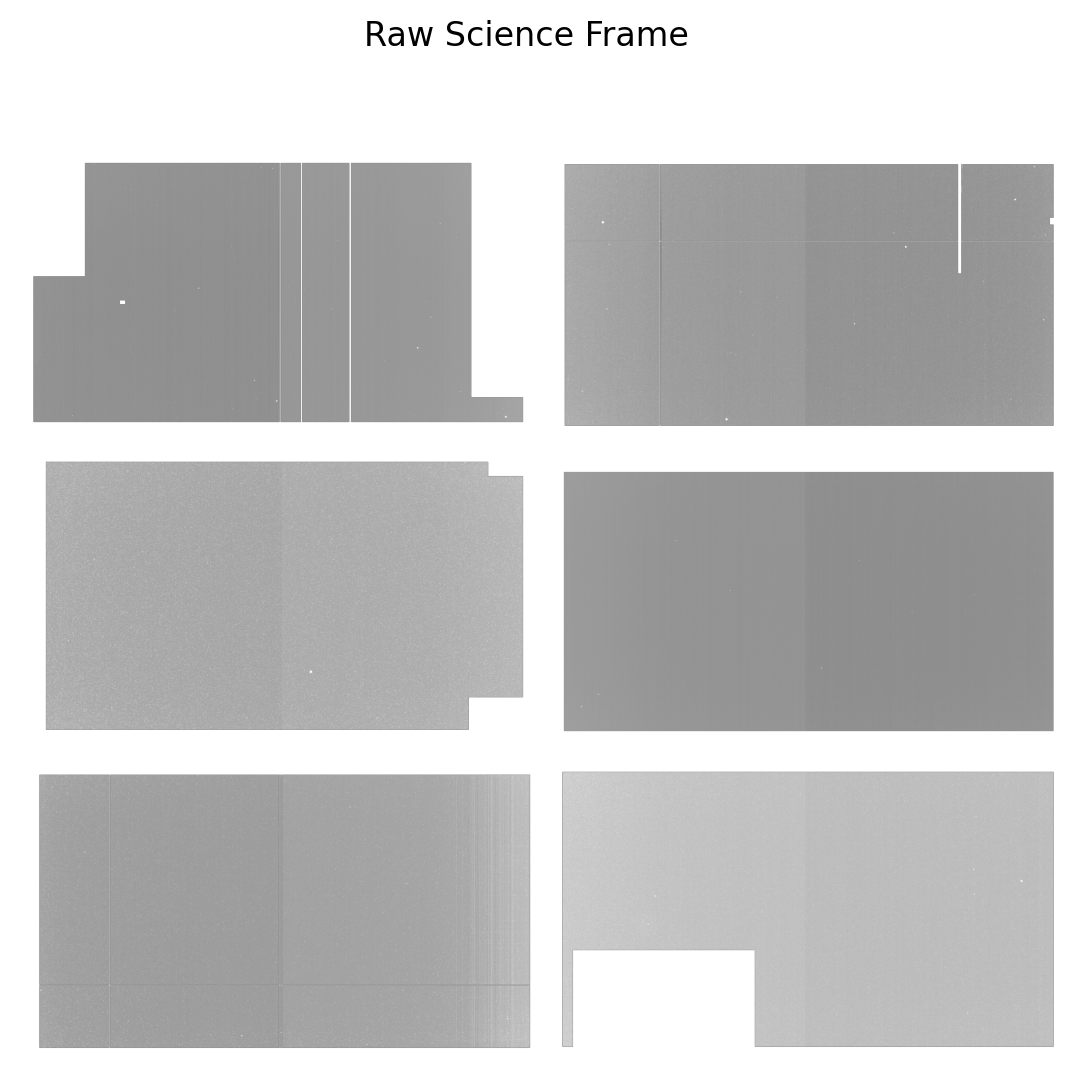

/Users/nlourie/Desktop/Work/MIT/WINTER/GIT/winter-image-daemon/imagedaemon/image/winter_image.py:608: RuntimeWarning: divide by zero encountered in divide
  return {k: op(self.data[k], other.data[k]) for k in common}
/Users/nlourie/Desktop/Work/MIT/WINTER/GIT/winter-image-daemon/imagedaemon/image/winter_image.py:608: RuntimeWarning: invalid value encountered in divide
  return {k: op(self.data[k], other.data[k]) for k in common}


Saving /Users/nlourie/data/image-daemon-data/raw/winter/science/30s/bkg/science_dark_flat_corr_sa.fits
Saving /Users/nlourie/data/image-daemon-data/raw/winter/science/30s/bkg/science_dark_flat_corr_sb.fits
Saving /Users/nlourie/data/image-daemon-data/raw/winter/science/30s/bkg/science_dark_flat_corr_sc.fits
Saving /Users/nlourie/data/image-daemon-data/raw/winter/science/30s/bkg/science_dark_flat_corr_pa.fits
Saving /Users/nlourie/data/image-daemon-data/raw/winter/science/30s/bkg/science_dark_flat_corr_pb.fits
Saving /Users/nlourie/data/image-daemon-data/raw/winter/science/30s/bkg/science_dark_flat_corr_pc.fits
Header: XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -32 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 1984                                                  NAXIS2  =                 1096                        

shape of median data: (1096, 1984)
shape of masterdark image: (1096, 1984)
shape of median data dark corrected: (1096, 1984)


/var/folders/v4/c0sck65j1l3cwj3lsnz2fs380000gn/T/ipykernel_47316/1117653302.py:146: RuntimeWarning: divide by zero encountered in divide
  data_dither_flat_corr = data / median_dither_flat
/Users/nlourie/Desktop/Work/MIT/WINTER/GIT/winter-image-daemon/.conda/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


 Guess RA/Dec from header: 269.788105266876, 44.1872816050607
Reading input file 1 of 1: "/Users/nlourie/data/image-daemon-data/raw/winter/science/30s/bkg/tmp/tmp.fits"...
Running command: /opt/homebrew/bin/image2pnm --infile /Users/nlourie/data/image-daemon-data/raw/winter/science/30s/bkg/tmp/tmp.fits --uncompressed-outfile /tmp/tmp.uncompressed.YCKjuJ --outfile /tmp/tmp.ppm.NaMWTW --ppm --mydir /opt/homebrew/bin/solve-field
Extracting sources...
Downsampling by 2...
simplexy: found 1176 sources.
Making source extraction overlay plot -- pnmfn = /tmp/tmp.ppm.NaMWTW
Solving...
fitsbin.c:449:read_chunk: Couldn't find table "kdtree_data_codes" in file "/opt/homebrew/Cellar/astrometry-net/0.97/data/index-52m1-35.fits"
index.c:329:index_reload: Failed to read star kdtree from file /opt/homebrew/Cellar/astrometry-net/0.97/data/index-52m1-35.fits
engine.c:199:engine_add_index: Failed to load index from path /opt/homebrew/Cellar/astrometry-net/0.97/data/index-52m1-35.fits
Failed to add index "

<Axes: title={'center': 'Solved Image'}>

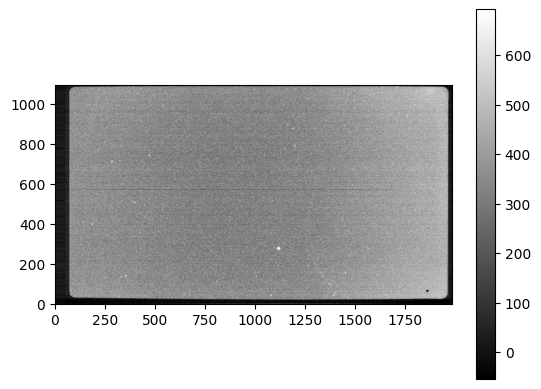

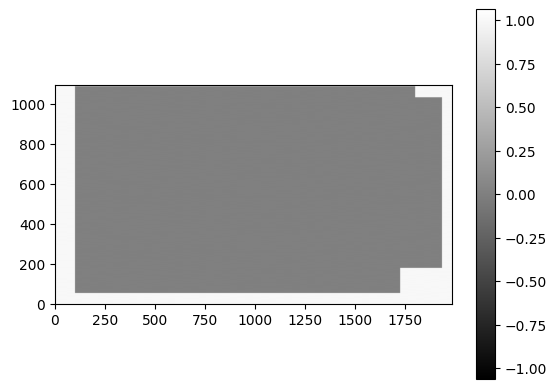

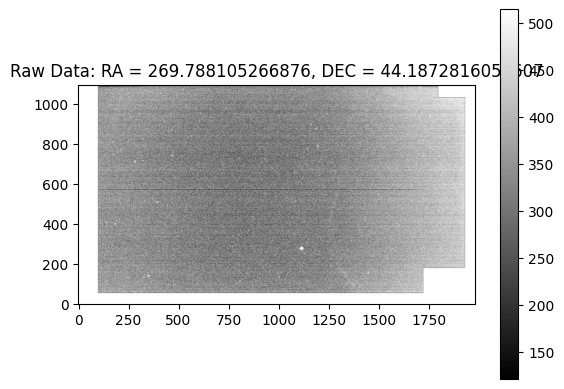

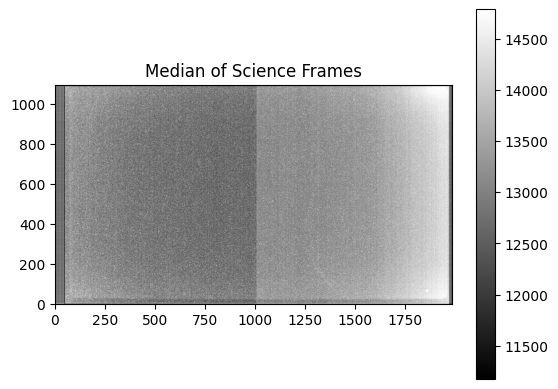

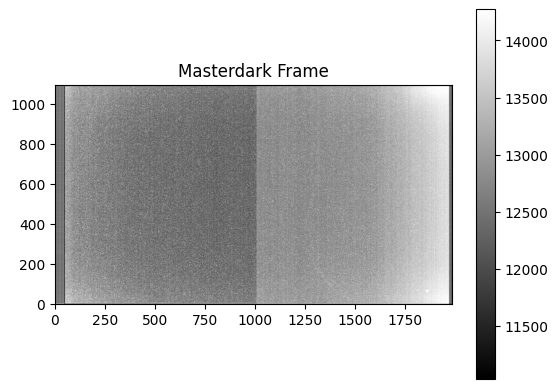

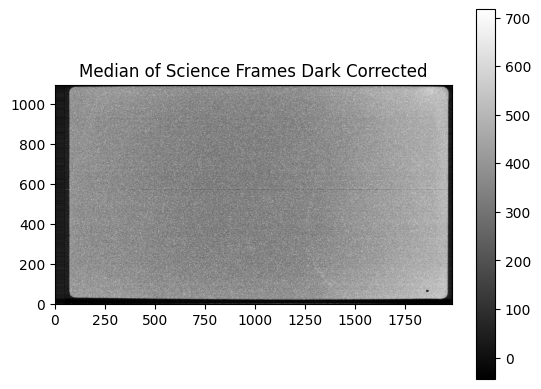

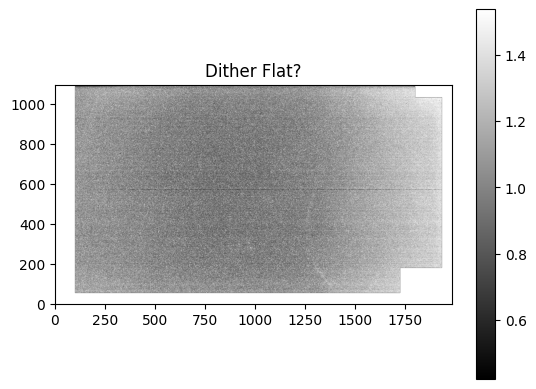

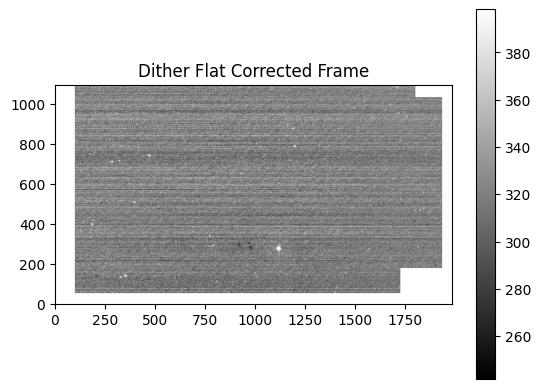

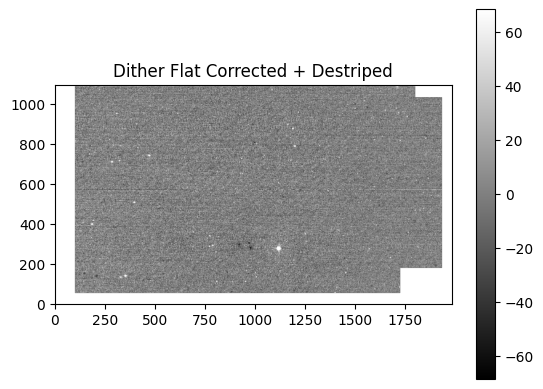

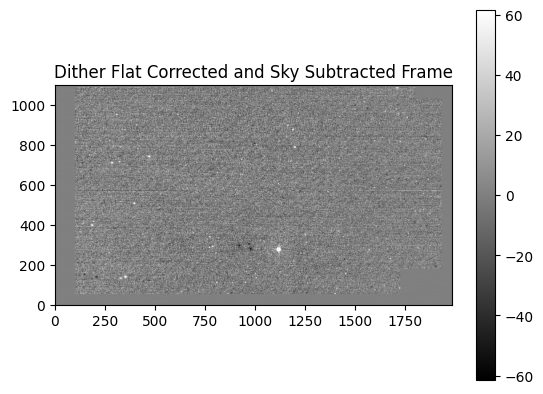

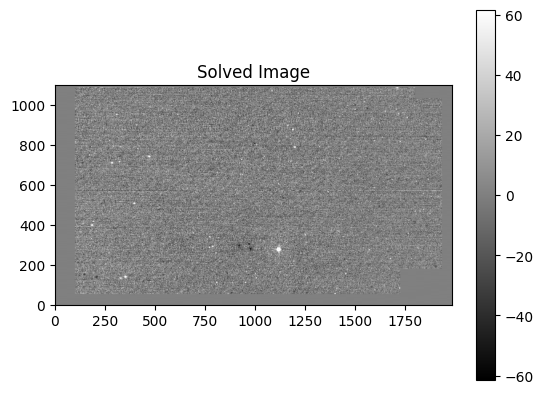

In [ ]:
import os
import numpy as np
import shlex
from astropy.io import fits
from glob import glob
import pandas as pd
from datetime import datetime
import subprocess
import sys
from pathlib import Path

from astropy.stats import SigmaClip
from photutils.background import Background2D, MedianBackground, SExtractorBackground

from imagedaemon.paths import CAL_DATA_DIR, RAW_DATA_DIR
from imagedaemon.image.winter_image import WinterImage
from imagedaemon.image.image_operations import plot_image, write_image

# Set up the paths to the calibration data
camname = "winter"
MASTERFLAT_DIR = os.path.join(CAL_DATA_DIR, camname, "masterflats")
MASTERDARK_DIR = os.path.join(CAL_DATA_DIR, camname, "masterdarks")
MASTERBIAS_DIR = os.path.join(CAL_DATA_DIR, camname, "masterbiases")


# set up paths to the raw data, we have data for 30s and 120s

# Now load in a science frame. We will calibrate it.
exptime_to_analyze = 30.
if exptime_to_analyze == 30:
    science_raw_dir = os.path.join(RAW_DATA_DIR, camname, "science", "30s", "bkg")
    science_raw_files = sorted(glob(os.path.join(science_raw_dir, "*.fits")))
    target_files = sorted(glob(os.path.join(RAW_DATA_DIR, camname, "science", "30s", "*.fits")))
    science_raw_file = target_files[-1]
elif exptime_to_analyze == 120:
    science_raw_dir = os.path.join(RAW_DATA_DIR, camname, "science")
    science_raw_files = sorted(glob(os.path.join(science_raw_dir, "*.fits")))
    science_raw_file = science_raw_files[0]
else:
    raise ValueError(f"exptime_to_analyze must be 30 or 120, not {exptime_to_analyze}")

# Load the science frame as a WinterImage
science_raw_image = WinterImage(science_raw_file)

# Load the master flat, dark, and bias frames
masterflat_image = WinterImage(os.path.join(MASTERFLAT_DIR, "masterflat.fits"))

# Get the dark frame at the same exposure time as the science frame. Raise an error if none is found.
exposure_time = science_raw_image.top_level_header["EXPTIME"]
print(f"Science image exposure time: {exposure_time} seconds")

masterdark_files = glob(os.path.join(MASTERDARK_DIR, "*.fits"))
for dark_file in masterdark_files:
    dark_image = WinterImage(dark_file)
    if dark_image.top_level_header["EXPTIME"] == exposure_time:
        print(f"Found masterdark with matching exposure time: {os.path.basename(dark_file)}")
        break
else:
    raise FileNotFoundError(f"No masterdark found with exposure time {exposure_time} seconds")
    

masterdark_image = WinterImage(masterdark_files[0])
print(f"shape of masterdark single image: {masterdark_image.data['pa'].shape}")
print(f"shape of raw science frame: {science_raw_image.data['pa'].shape}")

# plot the raw science frame
science_raw_image.plot_mosaic(title="Raw Science Frame")

# Dark correct the science frame
science_dark_corr = WinterImage(science_raw_image - masterdark_image, 
                                headers=science_raw_image.headers, 
                                top_level_header=science_raw_image.top_level_header)
#science_dark_corr.plot_mosaic(title="Dark Corrected Science Frame")

# Flat field correct the dark corrected frame
science_dark_flat_corr = WinterImage(science_dark_corr / masterflat_image, 
                                headers=science_raw_image.headers, 
                                top_level_header=science_raw_image.top_level_header)
#science_dark_flat_corr.plot_mosaic(title="Dark + Flat Corrected Science Frame")


science_dark_flat_corr.save_sensors(
    os.path.join(science_raw_dir, "science_dark_flat_corr.fits")
)

# Test out the mask generation
addr = "pb"
#img = science_dark_flat_corr
img = science_dark_corr



plot_image(img.data[addr])
plot_image(img.masks[addr])

data = img.data[addr]
mask = img.masks[addr]
header = img.headers[addr]
top_level_header = img.top_level_header
print(f"Header: {header}")

"""
# Test out on another file?
test_file_board_4 = os.path.join(os.path.dirname(RAW_DATA_DIR), "test", "winter", "test","WINTERcamera_20250221-073341-459_mef_4_0_0.fits")
print(f"Test File: {test_file_board_4}")
data = fits.getdata(test_file_board_4)
top_level_header = fits.getheader(test_file_board_4)
"""

data[mask] = np.nan

plot_image(data, title = f"Raw Data: RA = {top_level_header['RADEG']}, DEC = {top_level_header['DECDEG']}")



# Make sky model using multiple science frames
tmp_dir = os.path.join(science_raw_dir, "tmp")
if not os.path.exists(tmp_dir):
    os.makedirs(tmp_dir)
science_files = sorted(glob(os.path.join(science_raw_dir, "*mef.fits")))
# make winter images for each science file
science_images = []
for science_file in science_files:
    science_image = WinterImage(science_file)
    science_images.append(science_image)
    #plot_image(science_image.data[addr], title=os.path.basename(science_file))

median_data = np.nanmedian([img.data[addr] for img in science_images], axis=0)
plot_image(median_data, title="Median of Science Frames")
plot_image(masterdark_image.data[addr], title="Masterdark Frame")
print(f"shape of median data: {median_data.shape}")
print(f"shape of masterdark image: {masterdark_image.data[addr].shape}")

median_data_dark_corr = median_data - masterdark_image.data[addr]
print(f"shape of median data dark corrected: {median_data_dark_corr.shape}")
#median_data_dark_corr[mask] = np.nan
plot_image(median_data_dark_corr, title="Median of Science Frames Dark Corrected")

# turn the median into a flat?
median_dither_flat  = median_data_dark_corr / np.nanmedian(median_data_dark_corr)
median_dither_flat[mask] = np.nan
plot_image(median_dither_flat, title="Dither Flat?")


# divide the science frame by the dither flat
data_dither_flat_corr = data / median_dither_flat
data_dither_flat_corr[mask] = np.nan
plot_image(data_dither_flat_corr, title="Dither Flat Corrected Frame")
# save the dither flat corrected data to a new file
hdu_dither_flat_corr = fits.PrimaryHDU(data=data_dither_flat_corr, header=header)
#hdu_dither_flat_corr.writeto(os.path.join(tmp_dir, "tmp.fits"), overwrite=True)

# subtract the median background from the science frame
#data_dither_flat_corr_skysub = data_dither_flat_corr - np.nanmedian(data_dither_flat_corr)

# option: remove horiztonal stripes
vec = np.nanmedian(data_dither_flat_corr_skysub, axis=1)
horizontal_stripes = np.outer(vec, np.ones(data_dither_flat_corr_skysub.shape[1]))
data_dither_flat_corr_skysub -= horizontal_stripes
plot_image(data_dither_flat_corr_skysub, title="Dither Flat Corrected + Destriped")

# replace the masked and hot pixels with the median value
data_dither_flat_corr_skysub[mask] = np.nanmedian(data_dither_flat_corr_skysub)
data_dither_flat_corr_skysub[data_dither_flat_corr_skysub > 60000.] = np.nanmedian(data_dither_flat_corr_skysub)
plot_image(data_dither_flat_corr_skysub, title="Dither Flat Corrected and Sky Subtracted Frame")




# save the dither flat corrected and sky subtracted data to a new file
hdu_dither_flat_corr_skysub = fits.PrimaryHDU(data=data_dither_flat_corr_skysub, header=header)
output_filepath = os.path.join(tmp_dir, "tmp.fits")
hdu_dither_flat_corr_skysub.writeto(output_filepath, overwrite=True)

# This is the call: 
ra_guess = top_level_header["RADEG"]
dec_guess = top_level_header["DECDEG"]

#ra_guess = 269.8
#dec_guess = 44.2

print(f" Guess RA/Dec from header: {ra_guess}, {dec_guess}")
cmd = (
    "solve-field "
    "/Users/nlourie/data/image-daemon-data/raw/winter/science/30s/bkg/tmp/tmp.fits "
    "--scale-units arcsecperpix --scale-low 1.1 --scale-high 1.2 "
    "--overwrite"
    f" --ra {ra_guess} --dec {dec_guess} --radius 2 --downsample 2"
)

proc = subprocess.Popen(
    shlex.split(cmd),
    cwd = Path(cmd.split()[1]).parent,   # write aux files next to FITS
    env=os.environ,                            # inherit same PATH/vars as shell
    stdout=subprocess.PIPE,
    stderr=subprocess.STDOUT,
    text=True,
    bufsize=1                                  # line‑buffered
)

for line in proc.stdout:                       # read as it arrives → never blocks
    sys.stdout.write(line)

ret = proc.wait()
if ret:
    raise RuntimeError(f"solve-field exited with {ret}")

solved_image_file = os.path.join(tmp_dir, "tmp.new")
solved_image = fits.getdata(solved_image_file)
plot_image(solved_image, title="Solved Image")
